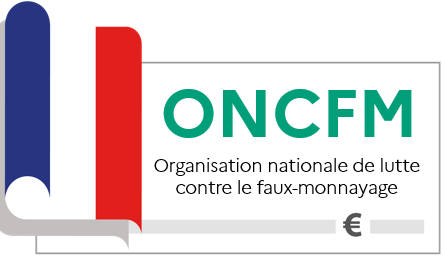

L’ONCFM souhaite développer une application de machine learning pour détecter automatiquement les faux billets en euros, à partir de caractéristiques physiques (longueur, hauteur, etc.).
Un jeu de 1500 billets scannés (1000 vrais / 500 faux) est fourni pour entraîner les modèles.
Sur recommandation de l’agence européenne EMV, quatre algorithmes seront testés en priorité :
K-means, Régression Logistique, KNN, Random Forest.
L’objectif final : mettre à disposition une application simple et efficace pour prédire la nature d’un billet à partir de ses caractéristiques.

#**Sommaire**


#1 - Traitements et analyses
*   1.1 - Import des librairies et chargement du fichier
*   1.2 - Analyse exploratoire du fichier
*   1.3 - Régression linéaire

#2 - Algorithmes et résultats
*   2.1 - Régression logistique
*   2.2 - Random Forest
*   2.3 - KNN
*   2.4 - K-means
*   2.5 - ACP

#3 - Modèle final et application
*   3.1 - Choix du modèle
*   3.2 - Sauvegarde du modèle
*   3.3 - Application

#**1** - Traitement et analyses

##**1.1** - Import des librairies et chargement du fichier

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import silhouette_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

In [ ]:
# Instruction permettant d'afficher toutes les colonnes d'un dataframe
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import du fichier billets.csv
df = pd.read_csv("/content/drive/MyDrive/OpenClassrooms/Projet 12/billets.csv", sep=";")

##**1.2** - Analyse exploratoire du fichier

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Le dataset contient

    ●  1500 échantillons

    ●  7 colonnes

Les 6 variables géométriques suivantes :

    ●  length : la longueur du billet (en mm) ;

    ●  height_left  :  la  hauteur  du  billet  (mesurée  sur  le  côté  gauche,  en mm) ;

    ●  height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;

    ●  margin_up  :  la  marge  entre  le  bord  supérieur  du  billet  et  l'image  de celui-ci (en mm) ;

    ●  margin_low  :  la  marge  entre  le  bord  inférieur  du  billet  et  l'image  de celui-ci (en mm) ;

    ●  diagonal : la diagonale du billet (en mm).


et une variable booléenne :

    ●  is_genuine : la nature du billet  (True/False)


La variable margin_low semble avoir 37 valeurs manquantes.

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
df.shape

(1500, 7)

In [ ]:
df.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [ ]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Hormis les valeurs manquantes de margin_low, pas de valeurs aberrantes à première vue.

In [ ]:
df.is_genuine.value_counts()

,count
is_genuine,
True,1000
False,500


1000 billets sont vrais parmis les 1500.

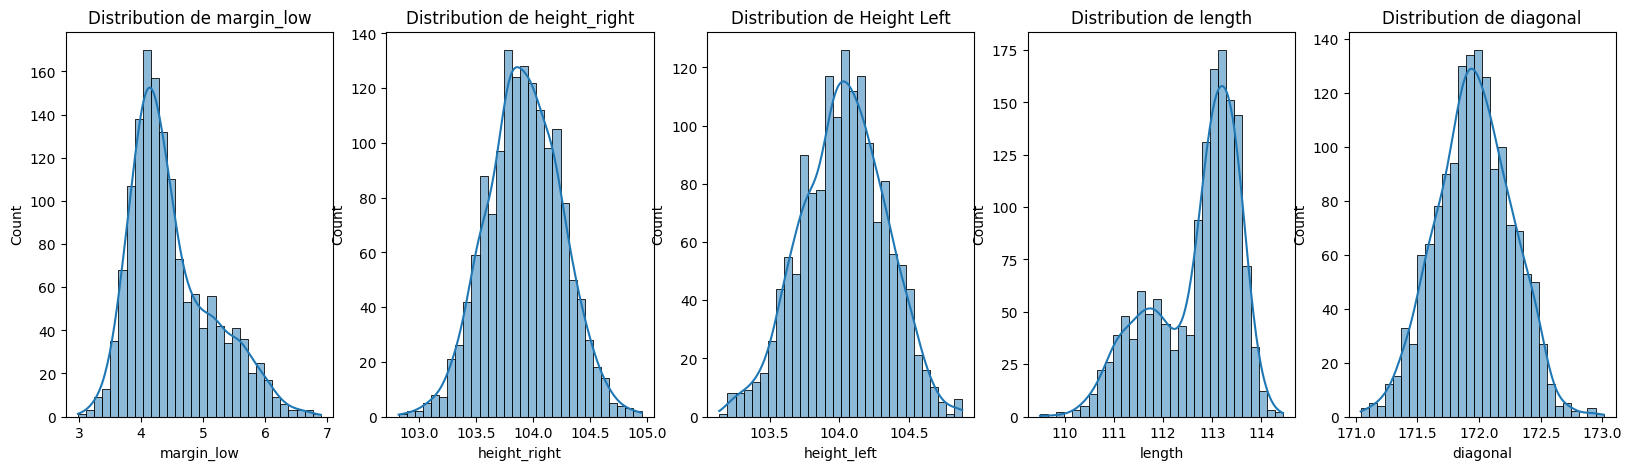

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(df['margin_low'], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Distribution de margin_low")

sns.histplot(df['height_right'], bins=30, kde=True, ax=ax[1])
ax[1].set_title("Distribution de height_right")

sns.histplot(df['height_left'], bins=30, kde=True, ax=ax[2])
ax[2].set_title("Distribution de Height Left")

sns.histplot(df['length'], bins=30, kde=True, ax=ax[3])
ax[3].set_title("Distribution de length")

sns.histplot(df['diagonal'], bins=30, kde=True, ax=ax[4])
ax[4].set_title("Distribution de diagonal")

plt.show()

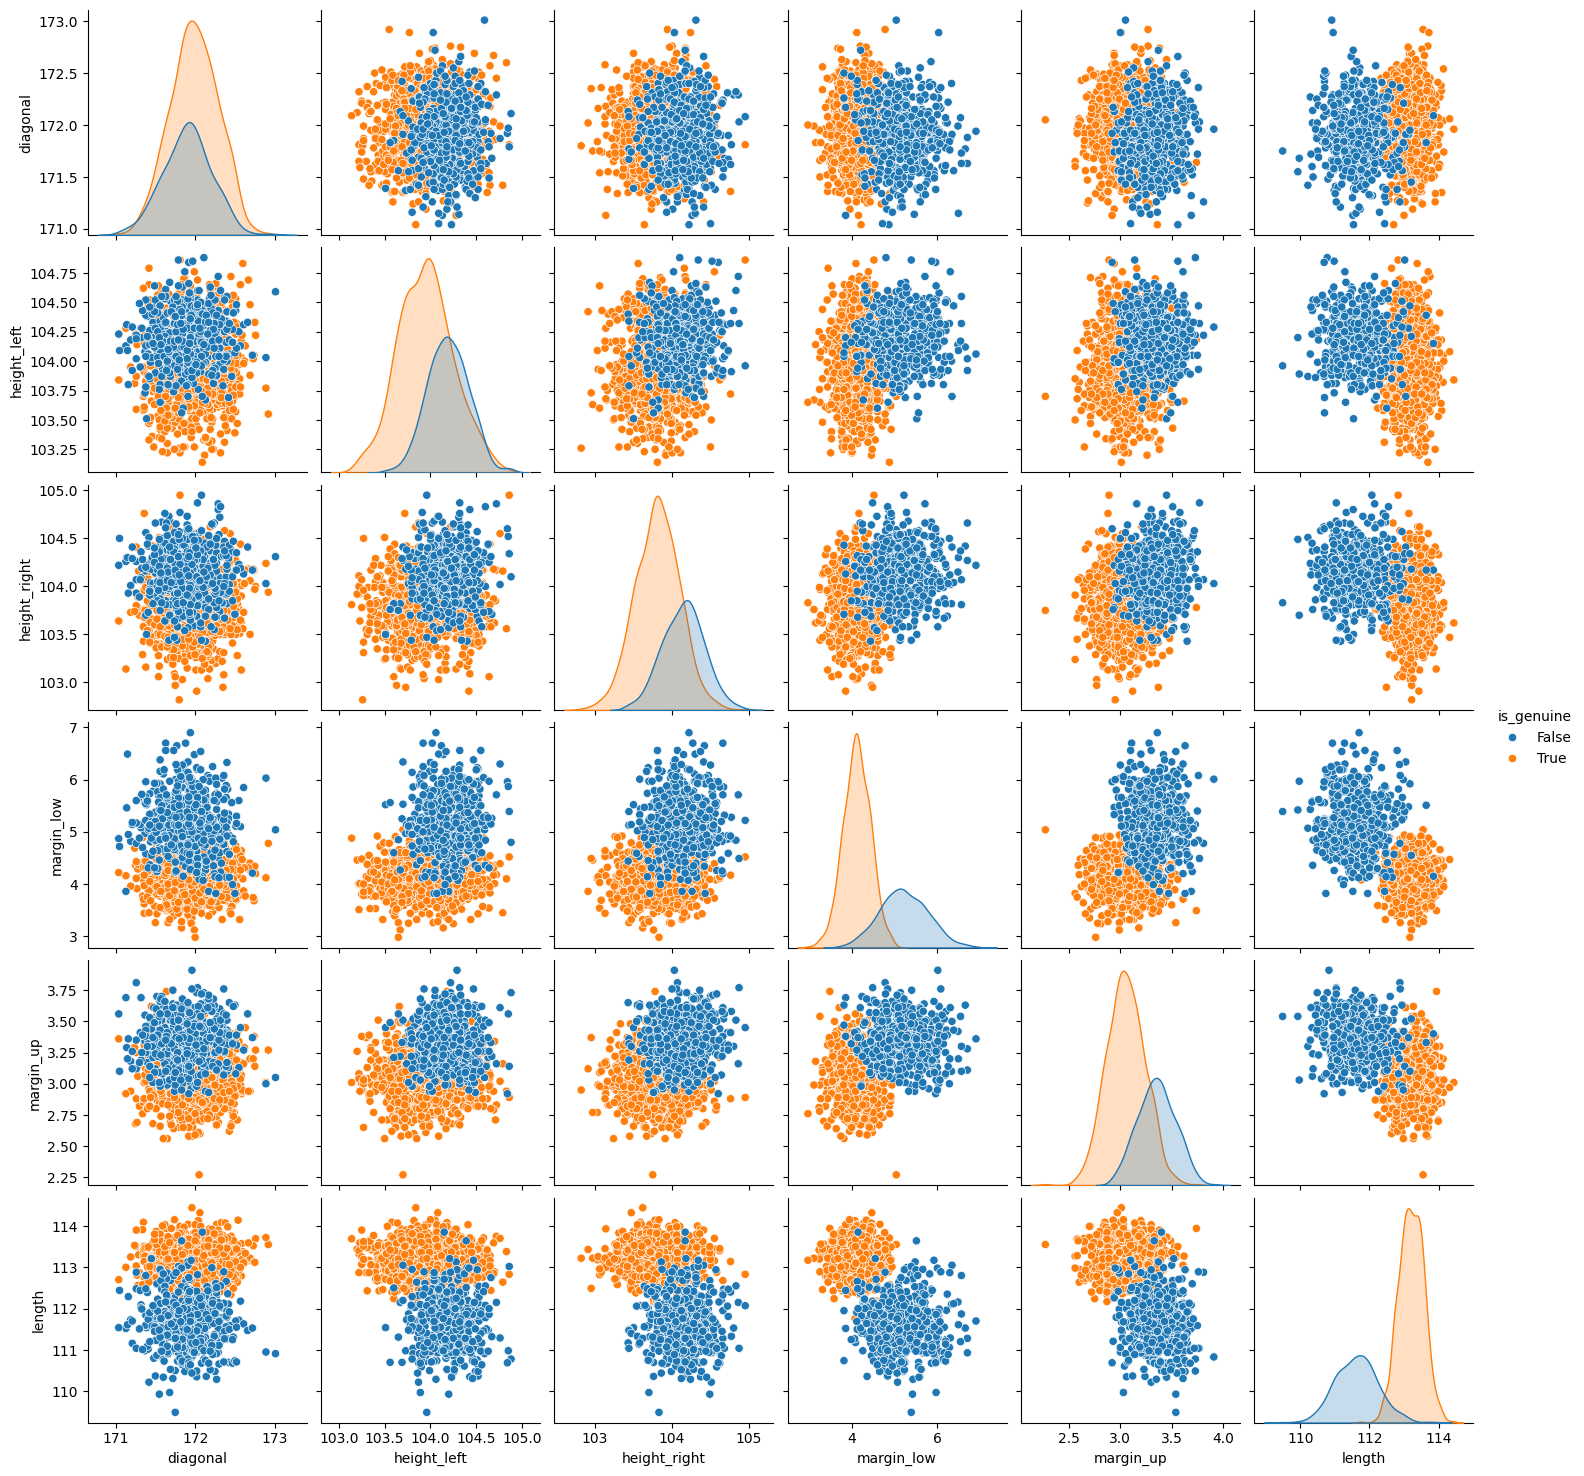

In [ ]:
sns.pairplot(df, hue='is_genuine')

**Length** et **margin_low** se distinguent à la fois par leur distribution et leur relation. Ces deux variables apparaissent comme particulièrement utiles pour distinguer les vrais billets des faux.

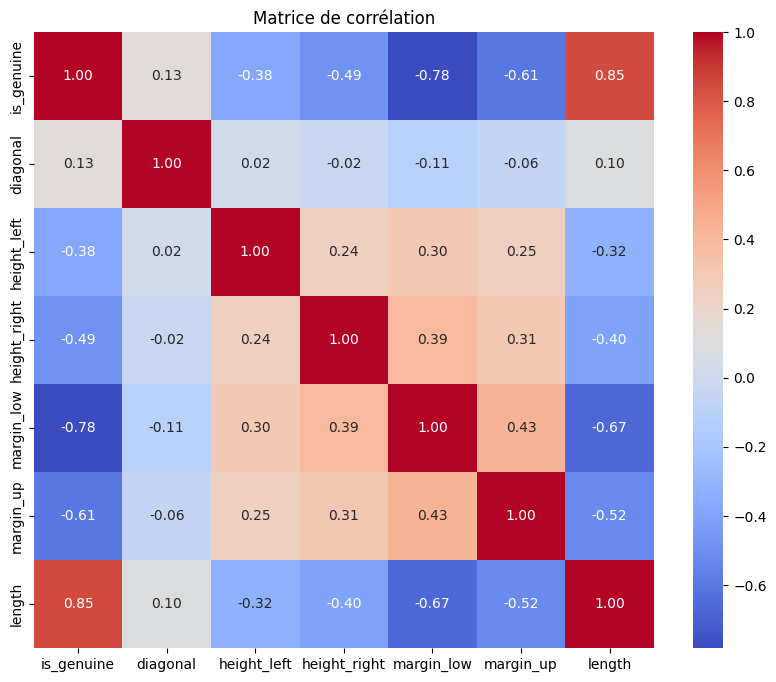

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

On observe une forte corrélation positive entre length et is_genuine (0.85), ainsi qu’une forte corrélation négative entre margin_low et is_genuine (-0.78). Cela confirme que ces variables apparaissent comme des indicateurs particulièrement pertinents pour discriminer les vrais billets des faux. D'autres variables comme margin_up ou height_right montrent également des corrélations notables.

##**1.3** - Régression linéaire

Je vais utiliser une régression linéaire pour prédire les valeurs manquantes de la colonne **margin_low**, en me basant sur les autres caractéristiques du billet.
Ce type de modèle est simple, rapide à mettre en place, et fonctionne bien quand il existe une relation linéaire entre les variables.
L’idée ici, est d’exploiter les données complètes pour apprendre cette relation et ensuite compléter les valeurs manquantes de façon cohérente, plutôt que de les ignorer ou de les remplir arbitrairement.

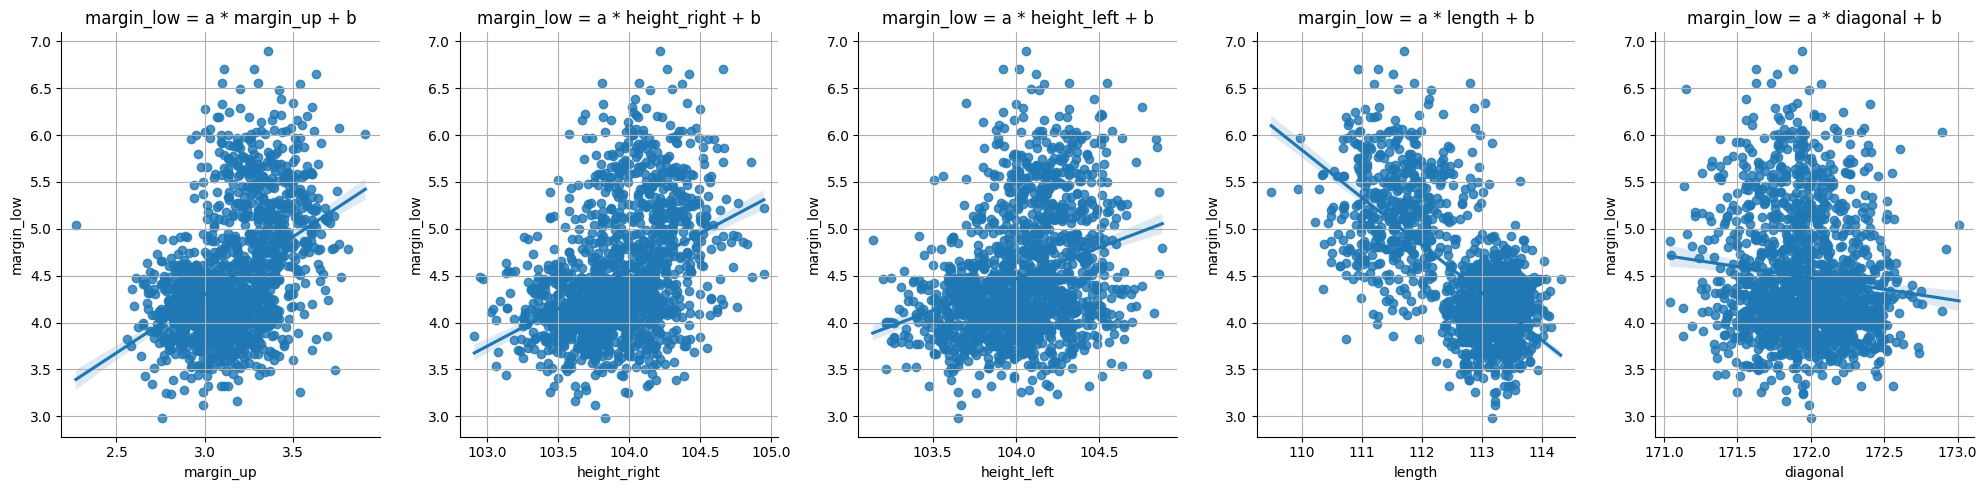

In [ ]:
df_known = df.dropna(subset=["margin_low"]) # Garde uniquement les lignes sans valeurs manquantes

# Variables à comparer à margin_low
features = ['margin_up', 'height_right', 'height_left', 'length', 'diagonal']

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i, feature in enumerate(features):
    sns.regplot(x=df_known[feature], y=df_known['margin_low'], ax=ax[i])
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('margin_low')
    ax[i].set_title(f'margin_low = a * {feature} + b')
    ax[i].grid()
    sns.despine(ax=ax[i])

plt.tight_layout()
plt.show()

Je vais transformer la variable is_genuine en chiffre pour l'intégrer aux variables explicatives et voir si cette variable à sa place parmis les autres.

In [ ]:
df_known["is_genuine_num"] = df_known["is_genuine"].astype(int)

<ipython-input-15-cc6988b606b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["is_genuine_num"] = df_known["is_genuine"].astype(int)


In [ ]:
corr_matrix = df_known[features + ["margin_low", "is_genuine_num"]].corr()
print(corr_matrix["margin_low"].sort_values(ascending=False))

margin_low        1.000000
margin_up         0.431606
height_right      0.391085
height_left       0.302643
diagonal         -0.111534
length           -0.666753
is_genuine_num   -0.783032
Name: margin_low, dtype: float64


Corrélations faible à modéré entre **margin_low** et la plupart des variables. **is_genuine_num** et **length** sortent du lot avec des corrélations fortes et négatives.


###VIF

Le VIF mesure si une variable explicative est trop corrélée aux autres.
Si le VIF est élevé, cela signifie que la variable apporte une information redondante, ce qui peut fausser la régression linéaire.
On utilise le VIF pour détecter et limiter la multicolinéarité entre les variables.

💡 En résumé : plus le VIF est élevé, plus la variable est "en trop" par rapport aux autres.

In [ ]:
# Definition des variables prédictrices
X = df_known[["margin_up", "height_right", "height_left", "diagonal", "length", "is_genuine_num"]]

# Ajout d'une constante
X = add_constant(X)

# Calcul du VIF de chaque variable
df_vif_data = pd.DataFrame()
df_vif_data['Feature'] = X.columns
df_vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
df_vif_data = df_vif_data[df_vif_data["Feature"] != "const"]
print(df_vif_data)

          Feature       VIF
1       margin_up  1.596090
2    height_right  1.320836
3     height_left  1.173711
4        diagonal  1.028199
5          length  3.613255
6  is_genuine_num  4.725732


L’ensemble des variables présente un VIF **inférieur à 5**, ce qui indique l’absence de multicolinéarité problématique.
Bien que nous ayons observé précédemment une corrélation relativement forte entre **length** et **is_genuine_num**, leurs VIF respectifs restent en dessous du seuil critique.
Cela est rassurant pour la suite de l’analyse, car cela signifie que ces variables peuvent être conservées dans le modèle sans risquer de fausser les estimations des coefficients.

### Train/Test (80/20)

Entrainons une régression linéaire pour prédire **margin_low** en fonction des variables **margin_up**, **heigh_right**, **heigh_left**, **length**, et **diagonal**

`margin_low ~ margin_up + heigh_right + heigh_left + length + diagonal`


Définissons pour cela `X`, la matrice des variables d'entrées et `y` le vecteur de la variable cible

In [ ]:
# Sélection des variables explicatives et de la cible
features = ["margin_up", "height_right", "height_left", "length", "diagonal"]
#features = ["margin_up", "is_genuine_num"]
X = df_known[features]
y = df_known["margin_low"]

Scindons le dataset en un partie **entraînement** (80%) et une partie **test** (20%). Comme nous ne gardons que les lignes ou **margin_low** n'est pas null, on prends **1170** échantillons pour entraîner le modèle et on mets **293** échantillons de coté pour l'évaluer.

In [ ]:
# Séparer en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

####1er essai

In [ ]:
import statsmodels.api as sm

X_with_const = sm.add_constant(X)  # Ajout de l'intercept
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")
print(f"R²: {r2_score(y_test, y_pred_test)}")

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 19 May 2025   Prob (F-statistic):          2.60e-202
Time:                        15:01:38   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

####2ème essai

Je vais ajouter **is_genuine_num** aux variables explicatives et comparer les résultats.

In [ ]:
# Sélection des variables explicatives et de la cible
features = ["margin_up", "height_right", "height_left", "length", "diagonal", "is_genuine_num"]
X = df_known[features]
y = df_known["margin_low"]

# Séparer en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

X_with_const = sm.add_constant(X)  # Ajout de l'intercept
model = sm.OLS(y, X_with_const).fit()
print(model.summary())
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")
print(f"R²: {r2_score(y_test, y_pred_test)}")

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 19 May 2025   Prob (F-statistic):          4.75e-299
Time:                        15:01:38   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.8668      8.316      0.

Les métriques globales du modèle sont meilleures, mais les **coefficients** et les **p-values** indiquent que la majorité des variables ne sont **pas significatives**. Seules deux variables semblent **réellement pertinentes** : **margin_up** et **is_genuine_num**. Je vais donc relancer un apprentissage (train/test) en ne conservant que ces deux variables, afin de comparer les performances.


####3ème essai

In [ ]:
# Sélection des variables explicatives et de la cible
features = ["margin_up", "is_genuine_num"]
X = df_known[features]
y = df_known["margin_low"]

# Séparer en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

X_with_const = sm.add_constant(X)  # Ajout de l'intercept
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")
print(f"R²: {r2_score(y_test, y_pred_test)}")

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 19 May 2025   Prob (F-statistic):          1.24e-304
Time:                        15:01:38   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.9263      0.198     30.

**RMSE** (Root Mean Squared Error) : **0.371** indique une erreur moyenne quadratique relativement faible, ce qui signifie que les prédictions sont globalement proches des valeurs réelles.

**MAE** (Mean Absolute Error) : **0.289** montre une erreur moyenne absolue raisonnable, ce qui confirme la stabilité du modèle face aux écarts individuels.

**MAPE** (Mean Absolute Percentage Error) : **6.50%**, un excellent score indiquant que les erreurs représentent en moyenne moins de 7 % des vraies valeurs.

**R²** (coefficient de détermination) : **0.674** signifie que le modèle explique environ 67.4 % de la variance de la variable cible. C’est un score tout à fait acceptable pour ce type de données, montrant que le modèle est pertinent sans être parfait.

Nous avons ici des métriques identiques tout en ayant un modèle beaucoup plus simple :

`margin_low ~ margin_up + is_genuine_num`

Une **p-value** inférieure **à 0.05** nous indique que ces deux variables explicatives sont statistiquement significatives, c’est-à-dire qu’elles ont une influence réelle sur la variable cible **margin_low**, avec un risque d’erreur inférieur à **5 %**.

Les **coefficients** de ces deux variables s’interprètent ainsi :

**margin_up** : -0.2119 → pour chaque millimètre supplémentaire sur la marge supérieure, la marge inférieure diminue en moyenne de 0.21 mm (toutes choses égales par ailleurs).

**is_genuine_num** : -1.1632 → un vrai billet (is_genuine = 1) présente une marge inférieure de -1.16 mm en moyenne par rapport à un faux billet (is_genuine = 0) (toutes choses égales par ailleurs).

C’est comme si le modèle disait :

"**Si on connaît la marge en haut et si le billet est vrai ou faux, je peux estimer la marge en bas, car elle varie logiquement avec ces deux éléments.**"

###Homoscédasticité

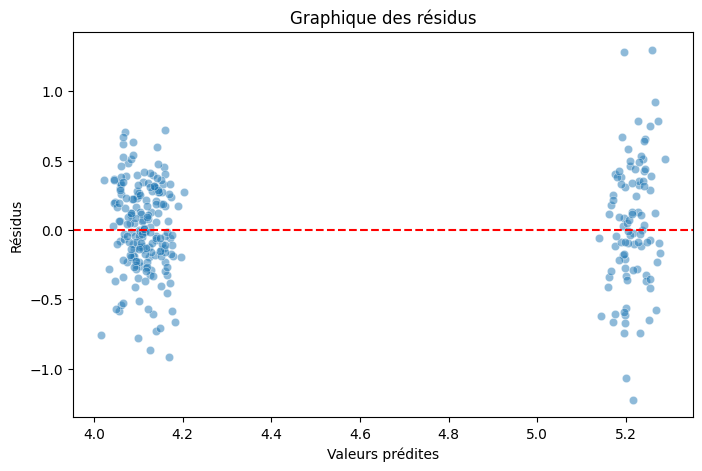

In [ ]:
# Calcul des résidus
residuals = y_test - y_pred_test

# Graphique des résidus
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='dashed')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus")
plt.show()

Le graphique des résidus met en évidence une **hétéroscédasticité** marquée, principalement due à la **structure binaire des données** (vrai/faux).

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Ajout de la constante à X_train
X_train_with_const = sm.add_constant(X_train)

# Calcul des résidus sur le TRAIN (pas le test)
residuals_train = y_train - reg.predict(X_train)

# Test de Breusch-Pagan sur les données d'entraînement
bp_test = het_breuschpagan(residuals_train, X_train_with_const)

# Affichage des résultats
print(f"Statistique de Breusch-Pagan: {bp_test[0]}")
print(f"P-value: {bp_test[1]}")


Statistique de Breusch-Pagan: 147.01551502317054
P-value: 1.1912050767104977e-32


In [ ]:
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

# Ajout de la constante si ce n'est pas déjà fait
X_train_with_const = sm.add_constant(X_train)

# Calcul des résidus
residuals = y_train - reg.predict(X_train)

# Test de White
white_test = het_white(residuals, X_train_with_const)

# Résultats
print(f"Statistique de White: {white_test[0]}")
print(f"P-value: {white_test[1]}")

Statistique de White: 148.78458463969474
P-value: 3.708214926278238e-31


Les tests de **Breusch-Pagan** (p-value ≈ 1.19e-32) et de **White** (p-value ≈ 3.70e-31) rejettent très largement l’hypothèse nulle d’homoscédasticité.

Cela signifie que la variance des résidus n’est pas constante, ce qui confirme la présence d’**hétéroscédasticité** dans les données.

Ce résultat est **cohérent avec le nuage de points** observé sur le graphique des résidus, ainsi qu’avec la **structure binaire** des données (vrais / faux billets), qui peut naturellement créer une variance différente selon les classes.

###Normalité des résidus

In [ ]:
# Calcul des résidus
residus = y_test - y_pred_test
residus

,margin_low
1208,-0.025078
178,0.165142
281,0.069013
561,-0.195100
891,0.201511
...,...
1491,-0.046773
493,0.193447
494,-0.017116
1080,0.425163


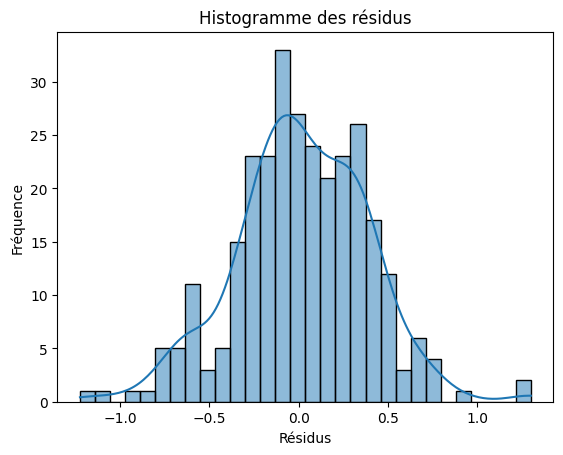

In [ ]:
sns.histplot(residus, bins=30, kde=True)
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.title("Histogramme des résidus")
plt.show()

La courbe ressemble à une **distribution normale**, mais il y a quelques asymétries et une légère concentration autour de 0.

Pas d’énormes écarts visibles, donc **la normalité n'est pas totalement violée**.

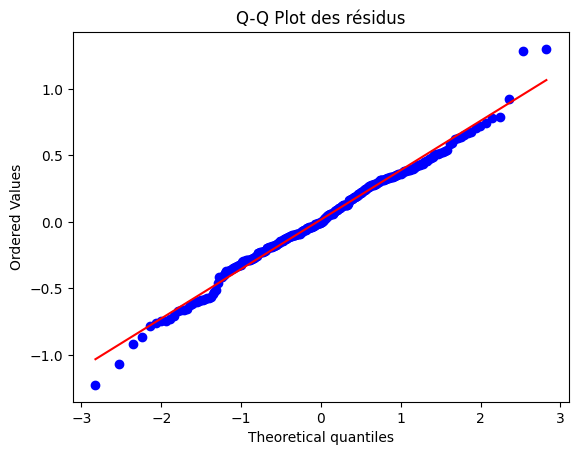

In [ ]:
import scipy.stats as stats

stats.probplot(residus, dist="norm", plot=plt)
plt.title("Q-Q Plot des résidus")
plt.show()

La plupart des points suivent bien la ligne rouge (ce qui est bon signe).

Par contre, aux extrémités (queue de la distribution), on voit quelques déviations, ce qui suggère des résidus légèrement plus extrêmes qu’une vraie distribution normale (présence de valeurs atypiques).

In [ ]:
from scipy.stats import shapiro

stat, p_value = shapiro(residus)
print(f"Statistique de test : {stat}, p-value : {p_value}")

if p_value > 0.05:
    print("Les résidus suivent une distribution normale (on ne rejette pas H0).")
else:
    print("Les résidus ne suivent pas une distribution normale (on rejette H0).")

Statistique de test : 0.9905826813181497, p-value : 0.05664457403361653
Les résidus suivent une distribution normale (on ne rejette pas H0).


In [ ]:
from scipy.stats import kstest

ks_stat, ks_p_value = kstest(residus, 'norm', args=(residus.mean(), residus.std()))
print(f"Statistique KS : {ks_stat}, p-value : {ks_p_value}")

if ks_p_value > 0.05:
    print("Les résidus suivent une distribution normale (on ne rejette pas H0).")
else:
    print("Les résidus ne suivent pas une distribution normale (on rejette H0).")

Statistique KS : 0.037243223284650295, p-value : 0.7967711677136543
Les résidus suivent une distribution normale (on ne rejette pas H0).


Le test de **Shapiro-Wilk** donne une p-value de 0.05, ce qui est juste à la limite du seuil de 5 %. Il **ne permet donc pas de rejeter l’hypothèse nulle** de normalité des résidus.

Le test de **Kolmogorov-Smirnov** donne une p-value de 0.79, ce qui confirme encore plus clairement qu’il n’y a **pas de violation de la normalité**.

Les **graphiques** (histogramme et Q-Q plot) confirment une **distribution globalement normale**, avec seulement un **léger écart en queue**.

**Conclusion** : les résidus peuvent être considérés comme **suffisamment normaux** pour valider l’hypothèse de normalité du modèle de régression.

###Validation croisée

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(reg, X, y, cv=cv, scoring='r2')

print("Scores de validation croisée :", scores)
print("Moyenne R² :", np.mean(scores))


Scores de validation croisée : [0.67362147 0.5971936  0.60745202 0.56695087 0.62631173]
Moyenne R² : 0.6143059373554809


Avec shuffle=True, les billets vrais et faux sont répartis aléatoirement dans chaque fold, ce qui permet une validation croisée plus représentative et donne un score R² cohérent autour de 0.61.

###Application de la régression linéaire sur nos données

In [ ]:
# 1. Sélection des variables explicatives et de la cible
df["is_genuine_num"] = df["is_genuine"].astype(int)
features = ["margin_up", "is_genuine_num"]
df_known = df.dropna(subset=["margin_low"])  # Garde les lignes avec "margin_low" connu

X = df_known[features]
y = df_known["margin_low"]

# 2. Entraînement sur 100% des données connues
reg = LinearRegression()
reg.fit(X, y)

# 3. Identifier les lignes où "margin_low" est manquant
df_missing = df[df["margin_low"].isna()]

# 4. Prédire les valeurs manquantes
if not df_missing.empty:
    X_missing = df_missing[features]
    df.loc[df["margin_low"].isna(), "margin_low"] = reg.predict(X_missing)

# Vérification
print("Nombre de valeurs manquantes après remplissage :", df["margin_low"].isna().sum())

Nombre de valeurs manquantes après remplissage : 0


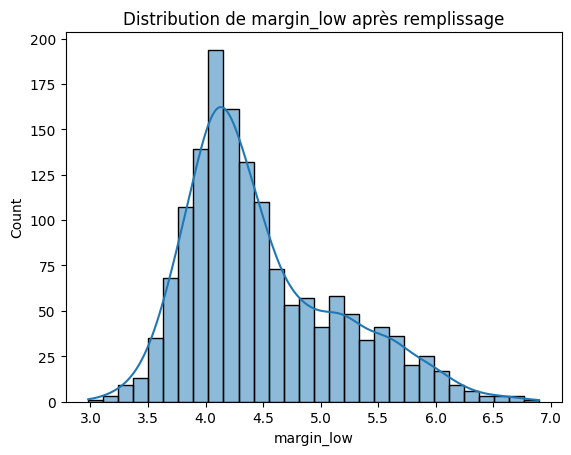

In [ ]:
sns.histplot(df["margin_low"], bins=30, kde=True)
plt.title("Distribution de margin_low après remplissage")
plt.show()

#**2** - Algorithmes et résultats

Avant d'appliquer les différents algorithmes, je vais d'abord sélectionner les features (X) et la cible (y), puis séparer les données en deux ensembles : entraînement et test.

In [ ]:
# Sélection des variables explicatives et de la cible
features = ["margin_up", "height_right", "height_left", "length", "diagonal", "margin_low"]
X = df[features]
y = df["is_genuine"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

## **2.1** - Régression logistique

La régression logistique est un algorithme de classification supervisée bien adapté aux problèmes où la variable cible est binaire. Dans notre cas, il s’agit de prédire si un billet est vrai ou faux, ce qui correspond parfaitement à ce type de modèle.

###Application du modèle

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

# Évaluation
y_pred_lr = lr.predict(X_test)

###Evaluation du modèle

####Matrice de confusion et scores

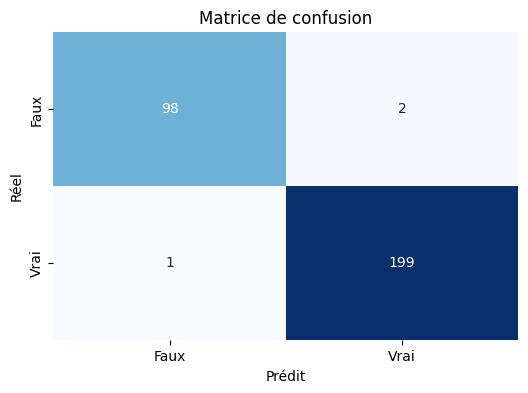

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_lr)

# Affichage avec seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()
print(classification_report(y_test, y_pred_lr))

**Precision** : parmi les billets que le modèle a prédits comme étant vrais (ou faux), combien le sont vraiment ?

**Recall** (ou sensibilité) : parmi les billets réellement vrais (ou faux), combien le modèle a bien retrouvés ?

**F1-score** : moyenne entre précision et rappel, utile quand on veut un équilibre.

**Support** : nombre de cas pour chaque classe dans le jeu de test (ici, 100 faux et 200 vrais).

**Accuracy** : (vrais positifs + vrais négatifs) / total = (98 + 199) / 300 = 99%

Le modèle est quasiment parfait, avec seulement **3 erreurs** sur 300 prédictions.

Il ne se trompe qu’**une seule fois sur un vrai billet**, ce qui est très rassurant si l’objectif est de ne pas rejeter un billet authentique.

En revanche, il commet **2 erreurs en prédisant à tort que des billets faux sont vrais**, ce qui montre une légère tendance à être trop confiant dans la prédiction de l’authenticité.

####Histogramme des probabilités

Text(0.5, 1.0, 'Histrogramme des probabilités')

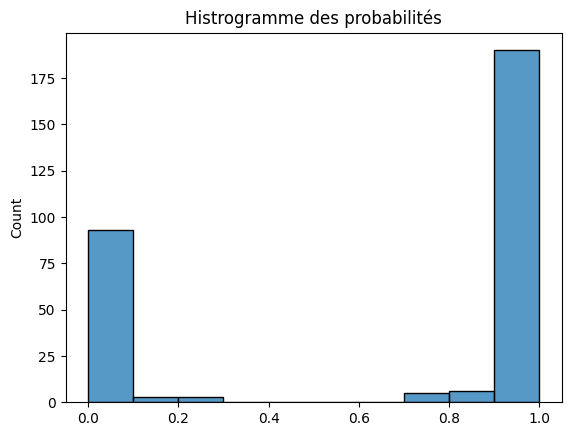

In [ ]:
y_proba = lr.predict_proba(X_test)[:,1]
sns.histplot(y_proba)
plt.title("Histrogramme des probabilités")

Le modèle est assez confiant de ses prédiction, la plupart des **prédictions ont une probabilité proche de 0 ou de 1**.

####Receiver Operating Characteristic (ROC)

In [ ]:
print("ROC-AUC", roc_auc_score(y_test, y_proba))

ROC-AUC 0.99935


Le score **ROC-AUC** obtenu (0.99) indique que le modèle **distingue presque parfaitement les vrais billets des faux**, en attribuant des probabilités de manière très fiable.

Text(0.5, 1.0, 'Courbe ROC')

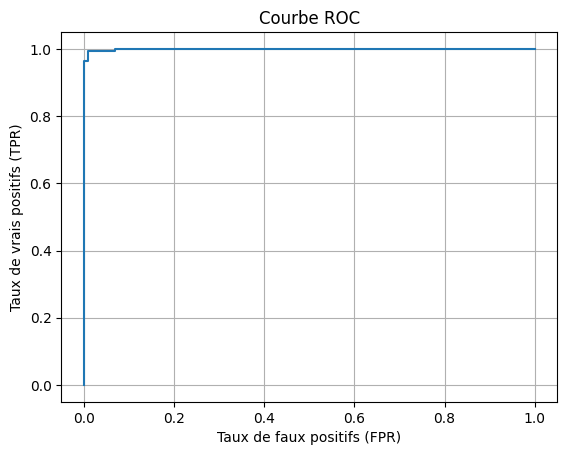

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title("Courbe ROC")

Le modèle a une **excellente capacité de discrimination**. La courbe ROC est très proche de l'angle supérieur gauche, ce qui indique peu de faux positifs et une très bonne détection des vrais positifs.

####Coefficients

In [ ]:
coeffs = lr.coef_[0]
odds_ratios = np.exp(coeffs)

# Associer les coefficients et odds à chaque variable
pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': coeffs,
    'Odds Ratio': odds_ratios
})

,Variable,Coefficient,Odds Ratio
0,margin_up,-3.044349,0.047627
1,height_right,-2.077448,0.125249
2,height_left,-1.313434,0.268895
3,length,3.916778,50.238292
4,diagonal,-0.359677,0.697901
5,margin_low,-3.519189,0.029623


**margin_up (-3.04 / OR = 0.048)**

➜ Plus la marge supérieure est grande, moins le billet a de chances d’être vrai.

➜ Une augmentation de 1 unité réduit les chances d’avoir un vrai billet d’environ 95%.

**height_right (-2.08 / OR = 0.125)**

➜ Une plus grande hauteur à droite réduit fortement la probabilité qu’un billet soit vrai.

**height_left (-1.31 / OR = 0.269)**

➜ Même interprétation : plus la hauteur à gauche est élevée, moins il est probable que le billet soit authentique.

**length (3.92 / OR = 50.24)**

➜ C’est la variable la plus discriminante : un billet plus long est beaucoup plus susceptible d’être vrai.

➜ Une augmentation d’1 unité multiplie les chances par 50 !

**diagonal (-0.36 / OR = 0.70)**

➜ Plus la diagonale est longue, légère baisse de la probabilité que le billet soit vrai.

**margin_low (-3.52 / OR = 0.030)**

➜ Une grande marge basse diminue énormément la probabilité que le billet soit authentique.

####Validation croisée

In [ ]:
from sklearn.model_selection import cross_val_score

# Score AUC sur 5 plis
auc_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')

print("Scores AUC par pli :", auc_scores)
print("AUC moyen :", np.mean(auc_scores))

Scores AUC par pli : [0.99984375 0.99992188 0.99140625 0.99953125 1.        ]
AUC moyen : 0.9981406249999999


####Changement de seuil

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Testons plusieurs seuils
seuils = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for seuil in seuils:
    y_pred_seuil = (y_proba >= seuil).astype(int)
    precision = precision_score(y_test, y_pred_seuil)
    recall = recall_score(y_test, y_pred_seuil)
    f1 = f1_score(y_test, y_pred_seuil)
    print(f"Seuil: {seuil}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-score:  {f1:.2f}")
    print("-" * 30)

Seuil: 0.2
  Precision: 0.98
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.3
  Precision: 0.99
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.4
  Precision: 0.99
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.5
  Precision: 0.99
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.6
  Precision: 0.99
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.7
  Precision: 0.99
  Recall:    0.99
  F1-score:  0.99
------------------------------
Seuil: 0.8
  Precision: 0.99
  Recall:    0.97
  F1-score:  0.98
------------------------------


Le seuil de 0.5 est déjà optimal et la modification de celui-ci n'apporte aucune plus-value.

##**2.2** - Random Forest

La Random Forest est un algorithme de classification supervisée basé sur un ensemble d'arbres de décision. Chaque arbre est entraîné sur un échantillon différent des données, et la prédiction finale est obtenue par vote majoritaire entre tous les arbres.
Il fonctionne très bien sur des problèmes de classification binaire comme le nôtre, où l’objectif est de prédire si un billet est vrai ou faux.

###Application du modèle

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

###Evaluation du modèle

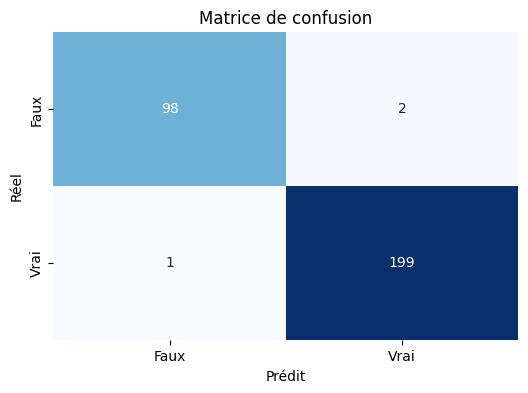

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Affichage avec seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()
print(classification_report(y_test, y_pred_rf))

Résultats identiques à ceux obtenus avec la régression logistique, en termes de score et d’erreurs de classification.

##**2.3** - KNN

Le K-Nearest Neighbors (KNN) est un algorithme de classification supervisée basé sur la notion de proximité. Pour prédire la classe d’un billet, le modèle regarde les k observations les plus proches dans l’espace des variables et prédit la classe majoritaire parmi elles.
Ce modèle est simple, intuitif, mais nécessite que les données soient bien normalisées, car il est sensible à l’échelle des variables.
Il est adapté à des tâches comme la nôtre, où on cherche à distinguer entre deux classes : vrais ou faux billets.

###Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
idx = ["mean", "std"]

pd.DataFrame(X_train_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.0,0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


###Application du modèle

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

#Prédictions
y_pred_knn = knn.predict(X_test_scaled)

###Evaluation du modèle

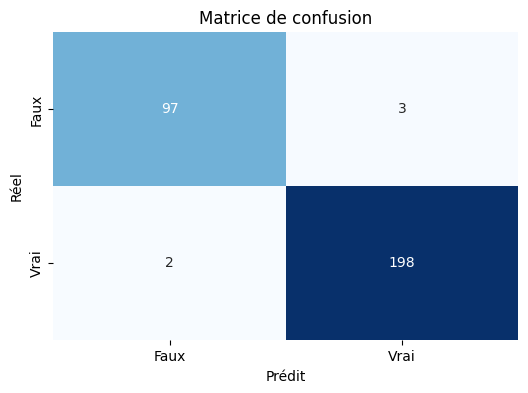

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       100
        True       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_knn)

# Affichage avec seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()
print(classification_report(y_test, y_pred_knn))

Modèle un peu moins performant que la régression logistique et la random forest.
Il confond 5 billets au total :

3 faux billets sont prédits comme vrais

2 vrais billets sont prédits comme faux

##**2.4** - K-means

K-Means est un algorithme de classification non supervisée qui regroupe les observations en k clusters en minimisant la distance entre les points et les centroïdes.
Il ne tient pas compte de la variable cible lors de l’entraînement, mais une comparaison a posteriori avec les vraies classes permet d’évaluer sa pertinence.
Dans ce projet, on utilise K-Means pour vérifier si une structure naturelle (2 groupes) émerge dans les données, correspondant aux vrais et faux billets. Cela permet de voir si une classification est possible sans supervision.

###Scaling

In [ ]:
# Pour K-means (on travaille sur tout X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

###Interties

In [ ]:
# Une liste vide pour enregistrer les inerties :
inertia_list = [ ]

# Notre liste de nombres de clusters :
k_list = range(1, 10)

# Pour chaque nombre de clusters :
for k in k_list :

    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++', max_iter=500, tol=1e-6)


    # On entraine
    kmeans.fit(X_scaled)

    # On enregistre l'inertie obtenue :
    inertia_list.append(kmeans.inertia_)

###Méthode du coude

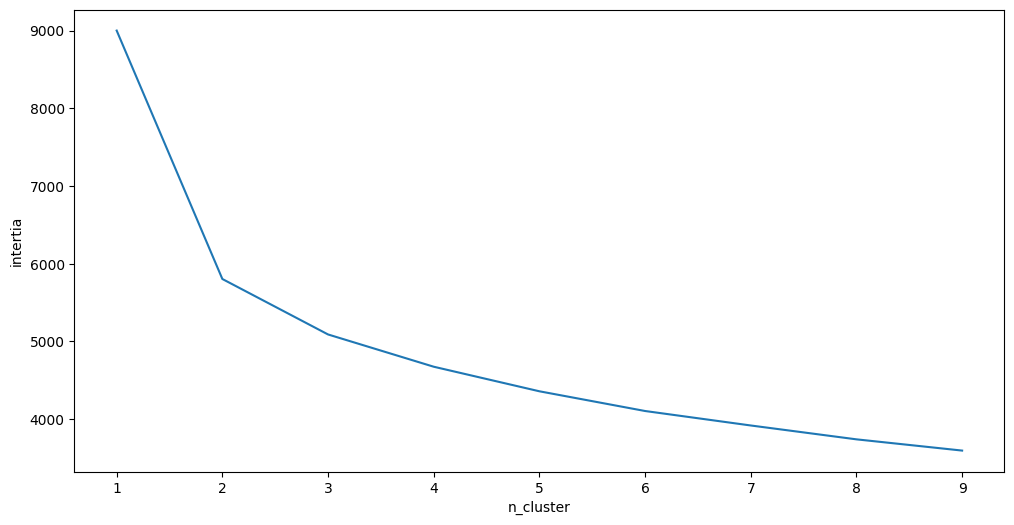

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, inertia_list)

Le graphique du coude montre une nette cassure à **k = 2**, ce qui suggère que deux clusters constituent le regroupement optimal. K-means parvient à séparer les données en deux groupes distincts, ce qui correspond potentiellement à la distinction entre billets vrais et billets faux.

###Clusters

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

In [ ]:
kmeans.labels_

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
labels = kmeans.labels_

In [ ]:
df_kmeans = df.copy()

In [ ]:
df_kmeans["cluster"] = labels
df_kmeans.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_num,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,0
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1,1


In [ ]:
display(df_kmeans["cluster"].value_counts())

,count
cluster,
1,1003
0,497


###Evaluation du modèle

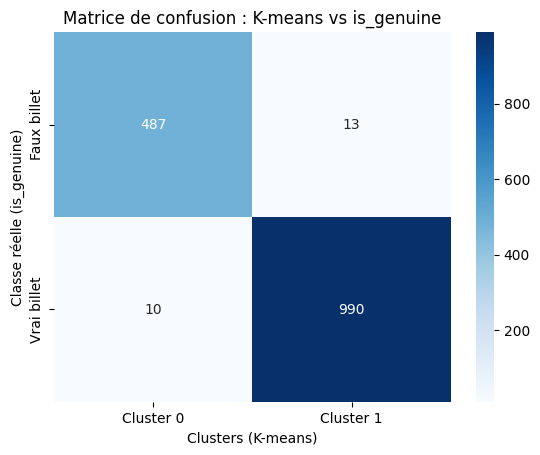

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:
# Matrice de confusion entre les clusters K-means et les vraies classes
cm = confusion_matrix(df_kmeans['is_genuine'], df_kmeans['cluster'])

# Affichage  avec seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cluster 0", "Cluster 1"],
            yticklabels=["Faux billet", "Vrai billet"])
plt.xlabel("Clusters (K-means)")
plt.ylabel("Classe réelle (is_genuine)")
plt.title("Matrice de confusion : K-means vs is_genuine")
plt.show()
print(classification_report(df_kmeans["is_genuine"], df_kmeans["cluster"]))

In [ ]:
# Création d'une colonne corrected si les clusters K-means sont inversés à l'exécution
df_kmeans["cluster_corrected"] = df_kmeans["cluster"].replace({0: 1, 1: 0})

# Rapport de classification
print(classification_report(df_kmeans["is_genuine"], df_kmeans["cluster_corrected"]))

              precision    recall  f1-score   support

       False       0.01      0.03      0.02       500
        True       0.02      0.01      0.01      1000

    accuracy                           0.02      1500
   macro avg       0.02      0.02      0.02      1500
weighted avg       0.02      0.02      0.01      1500



Le modèle K-means semble moins performant que les autres algorithmes supervisés, ce qui est attendu. Cependant, il est important de rappeler que K-means ne connaît pas les étiquettes des billets à l’avance. Malgré cela, il parvient à regrouper efficacement les billets en deux clusters cohérents, ce qui démontre une bonne capacité à détecter une structure naturelle dans les données.

##**2.5** - ACP

L’Analyse en Composantes Principales (ACP) est utilisée afin de réduire la dimension des données et de faciliter leur visualisation, tout en conservant l’essentiel de l’information. Nous allons vérifier si l'ACP permet de mieux observer les regroupements entre les billets vrais et faux.

###ACP

In [ ]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,-0.0,-0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#Nous allons travailler sur les 9 composantes
n_components = 6

In [ ]:
#On instancie l'ACP
pca = PCA(n_components=n_components)

In [ ]:
#On l'entraine sur les données scalées
pca.fit(X_scaled)

PCA(n_components=6)

###Variance & éboulis des valeurs propres

In [ ]:
#Variance captée par chaque composante
pca.explained_variance_ratio_

array([0.43204935, 0.16957137, 0.13019944, 0.11825183, 0.09666912,
       0.0532589 ])

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.2 , 16.96, 13.02, 11.83,  9.67,  5.33])

In [ ]:
#Somme cumulée des variances
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

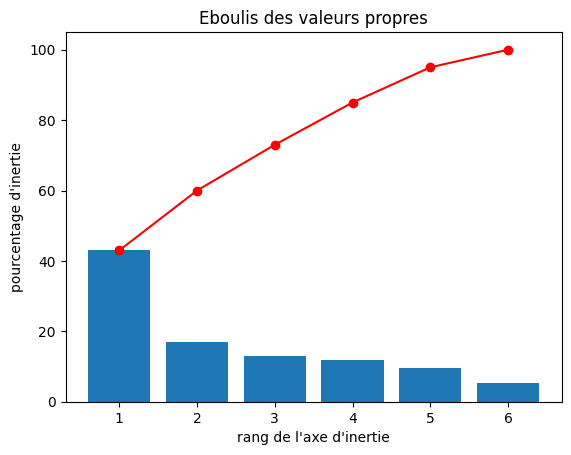

In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque composante, et en rouge la variance cumulée.

L’éboulis des valeurs propres montre que la première composante principale (**F1**) explique à elle seule une part importante de la variance (**plus de 40%**), justifiant son utilisation prioritaire pour la visualisation et l’analyse. Les composantes suivantes apportent une contribution décroissante, avec un intérêt secondaire à partir de F2.

###Composantes

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.T

,F1,F2,F3,F4,F5,F6
margin_up,-0.439317,-0.004428,-0.270938,-0.442677,0.710515,0.181048
height_right,-0.393761,0.108597,-0.165715,0.866852,0.232900,0.004710
height_left,-0.331333,0.307255,0.884792,-0.047614,0.103202,0.006187
length,0.527585,0.048706,0.149798,0.177236,0.300853,0.758234
diagonal,0.084840,0.941306,-0.287031,-0.102822,-0.117161,0.007730
margin_low,-0.506585,-0.073163,-0.106993,-0.091392,-0.570995,0.626246


<Axes: >

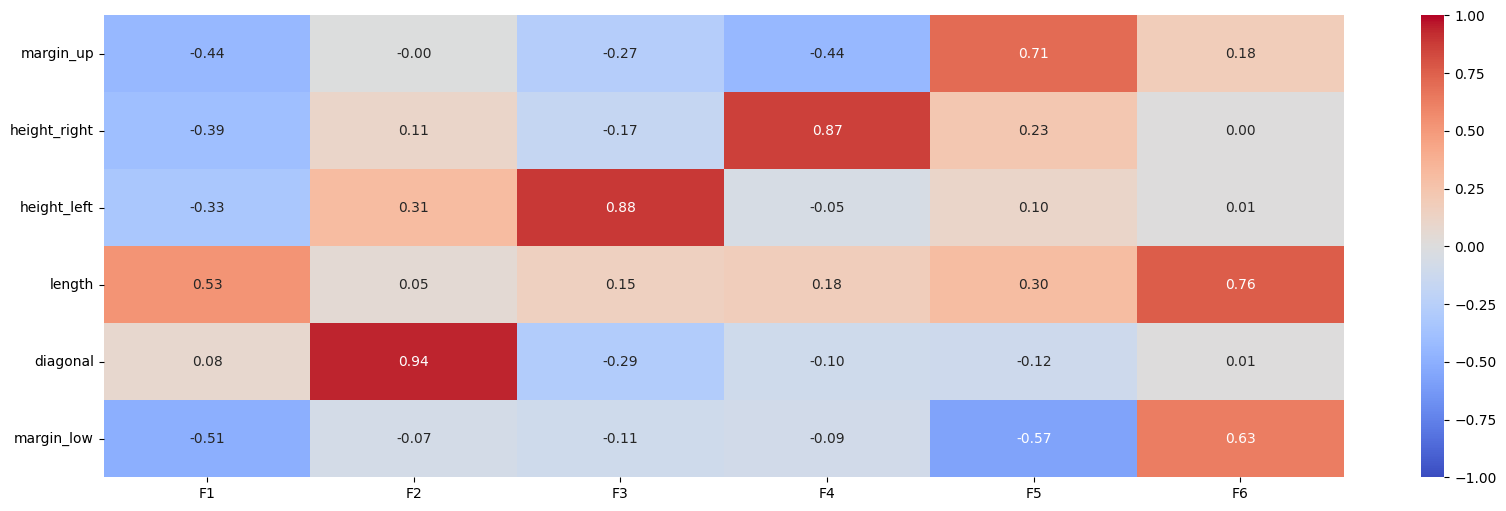

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

La composante principale **F1** apparaît comme la plus pertinente pour l’analyse, car elle est fortement corrélée aux variables **length** et **margin_low**, qui sont justement les deux variables les plus discriminantes pour déterminer **la véracité d’un billet**. Les composantes suivantes (F2, F3…) captent des variations secondaires moins utiles pour la visualisation ou la classification.

Pour une visualisation en deux dimensions, un graphique **F1 vs F2** est suffisant. La composante **F1** concentre l’essentiel de l’information utile à la distinction entre billets vrais et faux, tandis que **F2** apporte un complément visuel secondaire.

###Cercle des corrélations

In [ ]:
x, y = 0,1

In [ ]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [ ]:
x_y = (0,1)

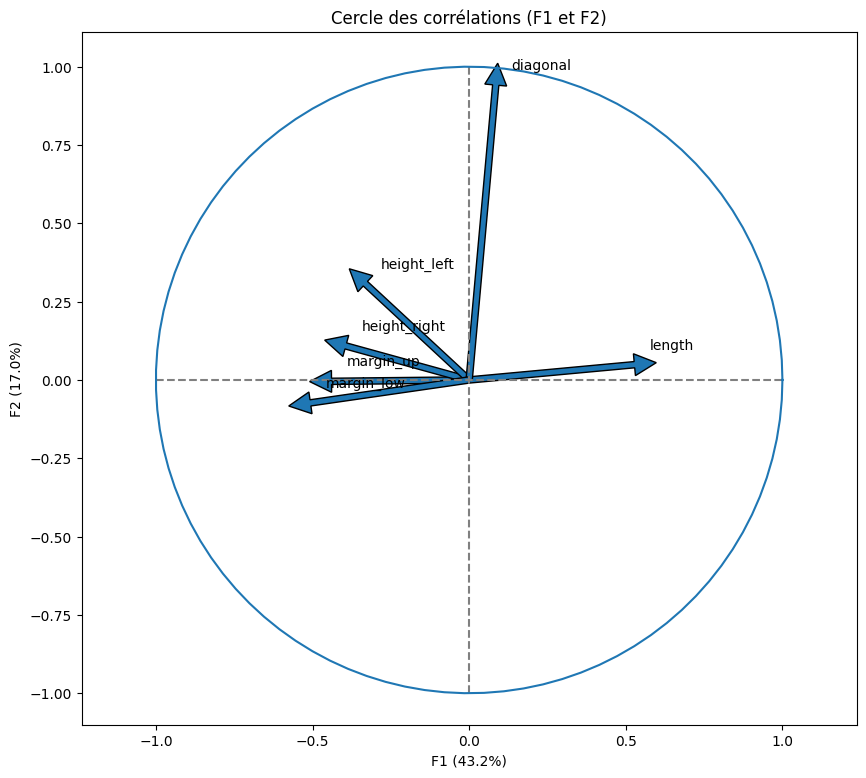

In [ ]:
correlation_graph(pca, x_y, features)

###Projection

In [ ]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj)
X_proj[:5]

,0,1,2,3,4,5
0,-1.647209,0.747235,2.395672,3.185117,0.298422,-0.009055
1,2.019737,-2.206741,-1.002349,0.072101,0.038243,-0.475539
2,0.968993,2.619321,1.200479,-0.924202,-0.836975,0.196348
3,1.375758,-1.817656,0.647826,0.831861,0.802583,-0.224417
4,-0.150385,-0.566191,0.853477,-1.782991,1.187610,-0.291424


In [ ]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette="Set1")

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :

        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

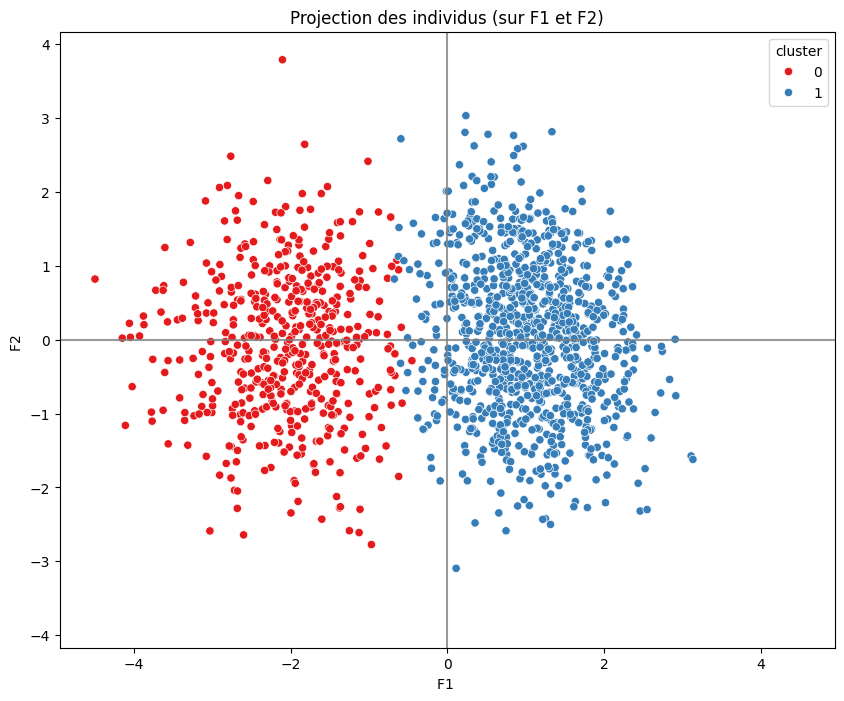

In [ ]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df_kmeans['cluster'])

Ce nuage de points confirme que la première composante principale **F1** est pertinente pour distinguer les billets vrais des faux. Il met également en évidence la capacité de **K-means** à séparer efficacement les deux groupes.

In [ ]:
import plotly.express as px
import pandas as pd

# Création d’un DataFrame avec les composantes principales
df_plot_3d = pd.DataFrame({
    'F1': X_proj.iloc[:, 0],
    'F2': X_proj.iloc[:, 1],
    'F3': X_proj.iloc[:, 2],
    'cluster': df_kmeans['cluster'].astype(str)  # pour une légende claire
})

# Scatter 3D avec Plotly
fig = px.scatter_3d(
    df_plot_3d,
    x='F1', y='F2', z='F3',
    color='cluster',
    title='Clusters K-means sur les composantes F1, F2 et F3 (ACP)',
    opacity=0.7
)
fig.show()

#**3** - Choix du modèle final et application

##**3.1** - Choix du modèle

J’ai retenu la **régression logistique** car elle offre le meilleur compromis entre performance, simplicité et interprétabilité. Elle rivalise avec la **random forest** en termes de score et de matrice de confusion, tout en étant plus légère et facile à exploiter. Le **K-means**, bien qu’étant un algorithme non supervisé, a montré une bonne capacité à distinguer vrais et faux billets, mais reste un peu moins performant, tout comme le **KNN**.

Application de la régression logistique à l'ensemble des données :

In [ ]:
X = df[features]
y = df["is_genuine"]

# Modèle
lr_full = LogisticRegression(max_iter=1000)
lr_full.fit(X, y)

# Prédictions
df["log_pred"] = lr_full.predict(X)

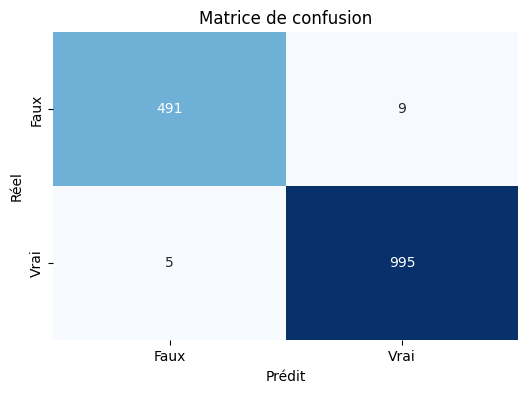

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



In [ ]:
# Matrice de confusion
cm = confusion_matrix(df["is_genuine"], df["log_pred"])

# Affichage avec seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()
print(classification_report(df["is_genuine"], df["log_pred"]))

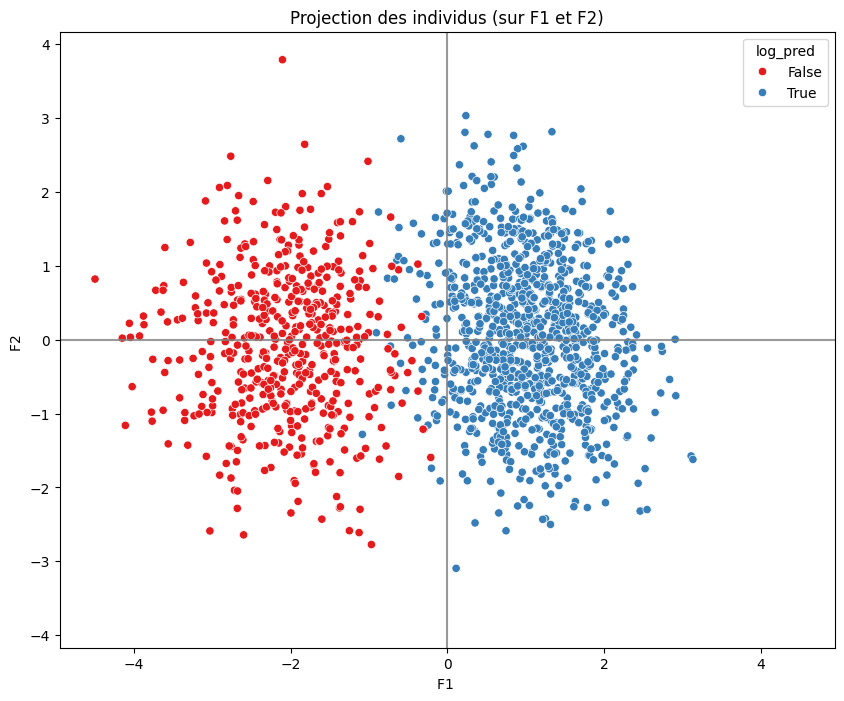

In [ ]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df['log_pred'])

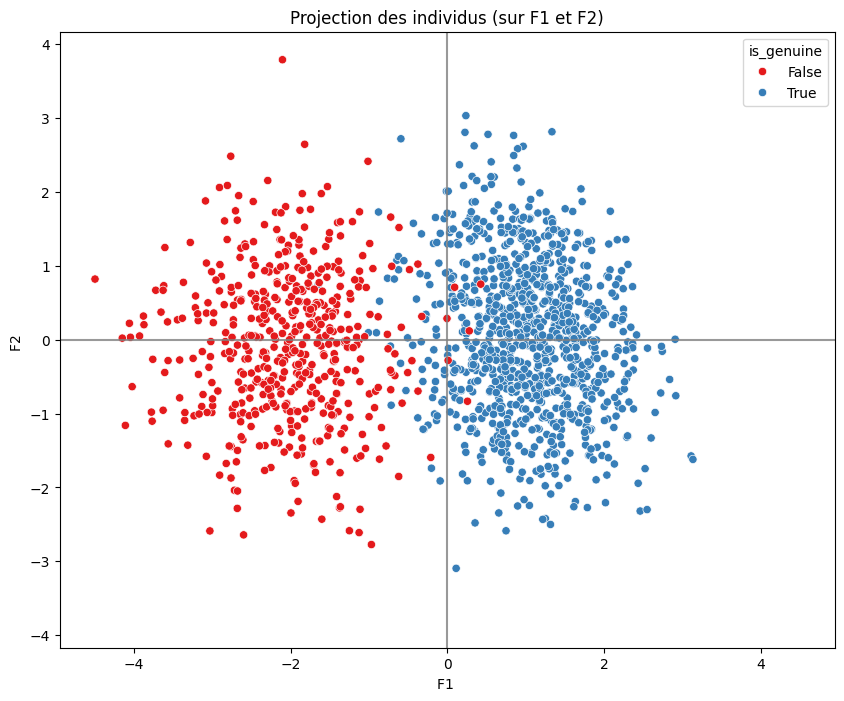

In [ ]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df['is_genuine'])

La régression logistique, comparée à la variable is_genuine, se défend très bien : la séparation entre les deux classes est nette et cohérente, ce qui témoigne de la qualité de ses prédictions. Les rares erreurs observées concernent des billets situés aux frontières des deux groupes, là où la distinction est naturellement plus délicate.

##**3.2** - Sauvegarde du modèle

Sauvegarde du modèle pour l'application

In [ ]:
import pickle

# Sauvegarde du modèle
with open("model_logreg.pkl", "wb") as f:
    pickle.dump(lr_full, f)

In [ ]:
from google.colab import files
files.download("model_logreg.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**3.3** - Application

L'application se trouve dans un notebook dédié.